#Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_ref=zipfile.ZipFile('/content/drive/MyDrive/dataset/images.zip','r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [3]:
# prompt: copy a file from one location to another

!cp /content/drive/MyDrive/dataset/captions.json /content/dataset


In [4]:
!pip install datasets
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 43.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-

#import necessary libraries

In [5]:
import torch
import torch.nn as nn
import math

#ImageFeatureExtrector

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomResNet152(nn.Module):
    def __init__(self, d_model):
        super(CustomResNet152, self).__init__()
        self.d_model=d_model

        self.base_model = models.resnet152(pretrained=True)
        # print(self.base_model)
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])
        # print(self.base_model)
        self.conv_layer = nn.Conv2d(2048, 4096, kernel_size=3, padding=1)
        # print(self.conv_layer)
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        # print(x.shape[0])
        batch_size=x.shape[0]
        base_model_out = self.base_model(x)
        # print('Base model size=====',base_model_out.size())
        # print('Base model=====',base_model_out)

        conv_out = self.conv_layer(base_model_out)
        # print("conv_out_size",conv_out.size())
        # print("conv_out",conv_out)
        reshaped_out = conv_out.view(batch_size,-1, self.d_model)
        # print(reshaped_out.size())
        return reshaped_out

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomResNet152(nn.Module):
    def __init__(self, d_model, num_fc_layers=2):
        super(CustomResNet152, self).__init__()
        self.d_model = d_model
        self.num_fc_layers = num_fc_layers

        self.base_model = models.resnet152(pretrained=True)
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])
        for param in self.base_model.parameters():
            param.requires_grad = False

        fc_layers = []
        in_features = 2048
        for i in range(num_fc_layers):
            out_features = in_features * 2
            fc_layers.append(nn.Linear(in_features, out_features))
            fc_layers.append(nn.ReLU(inplace=True))  # Apply ReLU activation
            in_features = out_features
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        batch_size = x.shape[0]
        base_model_out = self.base_model(x)
        fc_out = self.fc_layers(base_model_out.view(batch_size, -1))
        reshaped_out = fc_out.view(batch_size, -1, self.d_model)
        return reshaped_out


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomResNet152(nn.Module):
    def __init__(self, d_model, num_fc_layers=3, dropout_p=0.5):
        super(CustomResNet152, self).__init__()
        self.d_model = d_model
        self.num_fc_layers = num_fc_layers

        self.base_model = models.resnet152(pretrained=True)
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])
        for param in self.base_model.parameters():
            param.requires_grad = False

        fc_layers = []
        in_features = 2048
        for i in range(num_fc_layers):
            out_features = in_features * 2
            fc_layers.append(nn.Linear(in_features, out_features))
            fc_layers.append(nn.ReLU(inplace=True))  # Apply ReLU activation
            fc_layers.append(nn.Dropout(p=dropout_p))  # Add Dropout layer
            in_features = out_features
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        batch_size = x.shape[0]
        base_model_out = self.base_model(x)
        fc_out = self.fc_layers(base_model_out.view(batch_size, -1))
        reshaped_out = fc_out.view(batch_size, -1, self.d_model)
        return reshaped_out


# **CaptioningModel**

In [7]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
        # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [8]:

class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

In [9]:


class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # (batch, seq_len) --> (batch, seq_len, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.d_model)

In [10]:


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

In [11]:


class ResidualConnection(nn.Module):

        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)

        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

In [12]:


class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        return self.w_o(x)

In [13]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [14]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [15]:

class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [16]:

class Decoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

In [17]:

class ProjectionLayer(nn.Module):
    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)

In [18]:
class CaptioningModel(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, tgt_embed: InputEmbeddings, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer,customResnet:CustomResNet152) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_embed = tgt_embed
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer
        self.customResnet=customResnet

    def Resnet(self, src):
        src=self.customResnet(src)
        src_mask = torch.tensor([])  # Replace [] with appropriate dimensions

        for i in range(src.size(0)):
            tensor_to_concat = (torch.tensor([1 for j in range(src.size(1))]).to(torch.int)).unsqueeze(0).unsqueeze(0).unsqueeze(0)
            src_mask = torch.cat((src_mask, tensor_to_concat), dim=0).to(torch.int)
        return  src,src_mask

    def encode(self, src,src_mask):
        # src = self.tgt_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)

In [19]:
def build_caption_model(tgt_vocab_size: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> CaptioningModel:
    # Create the embedding layers
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)
    # src_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    #create cnn model
    customResnet=CustomResNet152(d_model)

    # Create the transformer
    transformer = CaptioningModel(encoder, decoder, tgt_embed, tgt_pos, projection_layer,customResnet)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

# **Config**

In [20]:
from pathlib import Path

def get_config():
    return {
        "batch_size": 8, #8,
        "num_epochs":20, #20,
        "lr": 10**-4,
        "seq_len":350, #350,
        "d_model":512, #512,
        "datasource": '/content/drive/MyDrive/experiments/experimentsone/opus_books',

        "lang_tgt": "bn",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "/content/drive/MyDrive/experiments/experimentsone/runs/tmodel"
    }

def get_weights_file_path(config, epoch: str):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}{epoch}.pt"
    return str(Path('.') / model_folder / model_filename)

# Find the latest weights file in the weights folder
def latest_weights_file_path(config):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}*"
    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None
    weights_files.sort()
    return str(weights_files[-1])


#**Dataset**

In [21]:
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.utils.data as dataSubset
from PIL import Image
import torchvision as tv
from transformers import BertTokenizer
import json
import os
import random
import numpy as np
import torchvision.transforms.functional as TF
class RandomRotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle, expand=True)





class CustomDataset(Dataset):
    def __init__(self,root_dir:str, mode, dataset_split_ratios:list, seq_len:int,tokenizer_src):

        super().__init__()

        self.root_dir=root_dir
        self.mode=mode
        self.dataset_split_ratio=dataset_split_ratios
        self.seq_len=seq_len

        self.image_dir=os.path.join(self.root_dir,'images')
        self.caption_dir=os.path.join(self.root_dir,'captions.json')
        self.caption=self.caption_formatter(self.readJsonFile(self.caption_dir))
        self.trainSplit,self.valSplit=dataset_split_ratios


        self.total_length = len(self.caption)
        self.train_length = int(self.total_length * self.trainSplit)  # 70% of the data for training
        self.val_length = int(self.total_length * self.valSplit)  # 15% of the data for validation
        self.test_length = self.total_length - self.train_length - self.val_length  # Remaining data for testing
        self.train_set,self.val_set,self.test_set=self.sequential_split(self.caption,[self.train_length,self.val_length,self.test_length])

        self.dataset=self.modeChecker()
        # self.tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base", do_lower=True)
        self.tokenizer = tokenizer_src
        self.pad_token=cls_id = self.tokenizer.convert_tokens_to_ids('[PAD]')

    def __len__(self):
        return len(self.dataset)

    def modeChecker(self):
        dataset=None
        if self.mode=='training':
            dataset=self.train_set
        elif self.mode=='validation':
            dataset=self.val_set
        elif self.mode=='testing':
            dataset=self.test_set

        return dataset

    def readJsonFile(self,directory:str):
        with open(directory,'r') as file:
            caption=json.load(file)
        return caption

    def _process(self, image_id):
        val = str(image_id)
        return val

    def sequential_split(self,dataset,lengths):
        train_length, val_length, test_length = lengths
        print(self.total_length,train_length, val_length, test_length,sum(lengths) )
        if sum(lengths) != self.total_length:
            raise ValueError("Sum of input lengths does not equal the length of the dataset")
        train_dataset = dataSubset.Subset(dataset, range(train_length))
        val_dataset = dataSubset.Subset(dataset, range(train_length, train_length + val_length))
        test_dataset = dataSubset.Subset(dataset, range(train_length + val_length, self.total_length))
        return train_dataset, val_dataset, test_dataset

    def caption_formatter(self,caption):
        caption_list=[]
        for items in caption:
            for caption in items['caption']:
                caption_list.append([items['filename'],caption])
        return caption_list

    def under_max(self, image):
        if image.mode != 'RGB':
            image = image.convert("RGB")
        MAX_DIM = 224

        shape = np.array(image.size, dtype=float)
        long_dim = max(shape)
        scale = MAX_DIM / long_dim

        new_shape = (shape * scale).astype(int)
        image = image.resize(new_shape)

        return image

    def transform(self, image):
        transformObj = None
        if self.mode == 'training':
            transformObj = tv.transforms.Compose([
                RandomRotation(),
                tv.transforms.Lambda(self.under_max),
                tv.transforms.ColorJitter(brightness=[0.5, 1.3], contrast=[0.8, 1.5], saturation=[0.2, 1.5]),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.Resize((224, 224)),  # Ensure all images are resized to 224x224
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            transformObj = tv.transforms.Compose([
                tv.transforms.Lambda(self.under_max),
                tv.transforms.Resize((224, 224)),  # Ensure all images are resized to 224x224
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        return transformObj(image)
    # def transform(self,image):
    #     transformObj=None
    #     if self.mode=='training':
    #         transformObj = tv.transforms.Compose([
    #             transforms.RandomResizedCrop(224),
    #             transforms.RandomHorizontalFlip(),
    #             transforms.ToTensor(),
    #             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #         ])
    #     else:
    #         transformObj = tv.transforms.Compose([
    #             transforms.Resize(256),
    #             transforms.CenterCrop(224),
    #             transforms.ToTensor(),
    #             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #         ])
    #     return transformObj(image)

    def encoder_ip_maker(self,caption):
        encoded_sentence = self.tokenizer(caption, add_special_tokens=False)
        cls_id = self.tokenizer.convert_tokens_to_ids('[CLS]')
        sep_id = self.tokenizer.convert_tokens_to_ids('[SEP]')
        encoded_with_cls_sep = [cls_id]+encoded_sentence["input_ids"] + [sep_id]
        return self.tokenizer.pad({"input_ids": encoded_with_cls_sep}, max_length=self.seq_len, padding="max_length", return_tensors="pt")  # Pad with padding token and convert to PyTorch tensor (optional)


    def label_maker(self,caption):
        encoded_sentence = self.tokenizer(caption, add_special_tokens=False)
        sep_id = self.tokenizer.convert_tokens_to_ids('[SEP]')
        encoded_with_sep = encoded_sentence["input_ids"] + [sep_id]
        return self.tokenizer.pad({"input_ids": encoded_with_sep}, max_length=self.seq_len, padding="max_length", return_tensors="pt")  # Pad with padding token and convert to PyTorch tensor (optional)


    def decoder_ip_maker(self,caption):
        encoded_sentence = self.tokenizer(caption, add_special_tokens=False)
        cls_id = self.tokenizer.convert_tokens_to_ids('[CLS]')
        encoded_with_cls = [cls_id]+encoded_sentence["input_ids"]
        return self.tokenizer.pad({"input_ids": encoded_with_cls}, max_length=self.seq_len, padding="max_length", return_tensors="pt")  # Pad with padding token and convert to PyTorch tensor (optional)



    def __getitem__(self, idx):
        image_id,caption=self.dataset[idx]
        image = Image.open( os.path.join(self.image_dir, image_id))
        # plt.imshow(image)
        image=self.transform(image)
        # print(image.size())
        encoder_input=self.encoder_ip_maker(caption)
        decoder_input=self.decoder_ip_maker(caption)
        label=self.label_maker(caption)

        # print("length: ",self.__len__())
        encoder_input=encoder_input["input_ids"] # (seq_len)
        # print("encoder_input",encoder_input)
        decoder_input=decoder_input["input_ids"]
        # print("decoder_input",decoder_input) # (seq_len)
        encoder_mask=(encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() # (1, 1, seq_len)
        # print( "encoder_mask",encoder_mask)
        decoder_mask=(decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)) # (1, seq_len) & (1, seq_len, seq_len),
        # print("decoder_mask",decoder_mask)
        label=label["input_ids"]
        # print("label",label)
        return {
            "image_src":os.path.join(self.image_dir, image_id),
            "image":image,
            # "encoder_input":encoder_input ,  # (seq_len)
            "decoder_input":decoder_input,  # (seq_len)
            # "encoder_mask": encoder_mask, # (1, 1, seq_len)
            "decoder_mask": decoder_mask, # (1, seq_len) & (1, seq_len, seq_len),
            "label": label,  # (seq_len)
            # "src_text": caption,
            "tgt_text": caption,
        }

def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

#**Training**

In [ ]:
import torchtext.datasets as datasets
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR


import warnings
from tqdm import tqdm
import os
from pathlib import Path

# Huggingface datasets and tokenizers
from transformers import BertTokenizer

from datasets import load_dataset
# from tokenizers import Tokenizer
# from tokenizers.models import WordLevel
# from tokenizers.trainers import WordLevelTrainer
# from tokenizers.pre_tokenizers import Whitespace

import torchmetrics
from torch.utils.tensorboard import SummaryWriter

def greedy_decode(model, source, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.convert_tokens_to_ids('[CLS]')
    eos_idx = tokenizer_tgt.convert_tokens_to_ids('[SEP]')

    # Precompute the encoder output and reuse it for every step
    resnet_output,source_mask = model.Resnet(source)
    source_mask=source_mask.to(device)
    encoder_output= model.encode(resnet_output, source_mask)
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input.to(torch.long), decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)


def run_validation(model, validation_ds, tokenizer_tgt, max_len, device, print_msg, global_step, writer, num_examples=2):
    model.eval()
    count = 0

    # source_texts = []
    expected = []
    predicted = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["image"].to(device) # (b, seq_len)
            # encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, tokenizer_tgt, max_len, device)

            # source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            # source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            # Print the source, target and model output
            print_msg('-'*console_width)
            # print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            if count == num_examples:
                print_msg('-'*console_width)
                break

    # if writer:
    #     # Evaluate the character error rate
    #     # Compute the char error rate
    #     metric = torchmetrics.CharErrorRate()
    #     cer = metric(predicted, expected)
    #     print("Character Error Rate (CER):", cer)
    #     writer.add_scalar('validation cer', cer, global_step)
    #     writer.flush()

    #     # Compute the word error rate
    #     metric = torchmetrics.WordErrorRate()
    #     wer = metric(predicted, expected)
    #     print("Word Error Rate (WER):", wer)
    #     writer.add_scalar('validation wer', wer, global_step)
    #     writer.flush()

    #     # Compute the BLEU metric
    #     metric = torchmetrics.BLEUScore()
    #     bleu = metric(predicted, expected)
    #     print("BLEU Score:", bleu)
    #     writer.add_scalar('validation BLEU', bleu, global_step)
    #     writer.flush()






def get_ds(config):
    # ds_raw = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train')
    root_dir='/content/dataset'

    # tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base", do_lower=True)


    ds_split_ratio=[0.4,0.15]

    train_ds = CustomDataset( root_dir ,'training' , ds_split_ratio, config['seq_len'],tokenizer_tgt )
    val_ds = CustomDataset( root_dir ,'validation' , ds_split_ratio, config['seq_len'],tokenizer_tgt )

    # Find the maximum length of each sentence in the source and target sentence
    # max_len_src = 0
    # max_len_tgt = 0

    # for item in ds_raw:
    #     src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
    #     tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
    #     max_len_src = max(max_len_src, len(src_ids))
    #     max_len_tgt = max(max_len_tgt, len(tgt_ids))

    # print(f'Max length of source sentence: {max_len_src}')
    # print(f'Max length of target sentence: {max_len_tgt}')


    # train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'],num_workers=4, shuffle=True)
    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    # val_dataloader = DataLoader(val_ds, batch_size=1, num_workers=4,shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_tgt

def get_model(config, vocab_tgt_len):
    print(config['d_model'])
    model = build_caption_model(vocab_tgt_len, config['seq_len'], d_model=config['d_model'])
    return model

def train_model(config):
    # Define the device
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    elif (device == 'mps'):
        print(f"Device name: <mps>")
    else:
        print("NOTE: If you have a GPU, consider using it for training.")
        print("      On a Windows machine with NVidia GPU, check this video: https://www.youtube.com/watch?v=GMSjDTU8Zlc")
        print("      On a Mac machine, run: pip3 install --pre torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/nightly/cpu")
    device = torch.device(device)

    # Make sure the weights folder exists
    Path(f"{config['datasource']}_{config['model_folder']}").mkdir(parents=True, exist_ok=True)

    train_dataloader, val_dataloader, tokenizer_tgt = get_ds(config)

    model = get_model(config, tokenizer_tgt.vocab_size).to(device)
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

    # If the user specified a model to preload before training, load it
    initial_epoch = 0
    global_step = 0
    preload = config['preload']
    model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None
    if model_filename:
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    else:
        print('No model to preload, starting from scratch')

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_tgt.convert_tokens_to_ids('[PAD]'), label_smoothing=0.1).to(device)

    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:


            encoder_input = batch['image'].to(device)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

            # Run the tensors through the encoder, decoder and the projection layer
            resnet_output,encoder_mask  =model.Resnet(encoder_input)
            encoder_mask=encoder_mask.to(device)
            encoder_output= model.encode(resnet_output, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            # Compare the output with the label
            label = batch['label'].to(device) # (B, seq_len)

            # Compute the loss using a simple cross entropy
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.vocab_size), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            # Log the loss
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        # Run validation at the end of every epoch
        run_validation(model, val_dataloader, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)


if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    config = get_config()
    train_model(config)


KeyboardInterrupt: 

#TrainingModified

In [ ]:
import torchtext.datasets as datasets
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR


import warnings
from tqdm import tqdm
import os
from pathlib import Path

# Huggingface datasets and tokenizers
from transformers import BertTokenizer

from datasets import load_dataset
# from tokenizers import Tokenizer
# from tokenizers.models import WordLevel
# from tokenizers.trainers import WordLevelTrainer
# from tokenizers.pre_tokenizers import Whitespace

import torchmetrics
from torch.utils.tensorboard import SummaryWriter

def greedy_decode(model, source, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.convert_tokens_to_ids('[CLS]')
    eos_idx = tokenizer_tgt.convert_tokens_to_ids('[SEP]')



    # Precompute the encoder output and reuse it for every step
    resnet_output,source_mask = model.Resnet(source)
    source_mask=source_mask.to(device)
    encoder_output= model.encode(resnet_output, source_mask)
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input.to(torch.long), decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break


    return decoder_input.squeeze(0)


def run_validation(model, validation_ds, tokenizer_tgt, max_len, device, print_msg, global_step, writer, loss_fn, num_examples=2):
    model.eval()
    count = 0
    total_loss = 0
    # source_texts = []
    expected = []
    predicted = []
    # loss_fn = nn.CrossEntropyLoss( ignore_index=float(tokenizer_tgt.convert_tokens_to_ids('[PAD]')),label_smoothing=0.1).to(device)
    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["image"].to(device) # (b, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)
            label = batch['label'].to(device)


            # check that the batch size is 1
            assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, tokenizer_tgt, max_len, device)




            resnet_output,encoder_mask  =model.Resnet(encoder_input)
            encoder_mask=encoder_mask.to(device)
            encoder_output= model.encode(resnet_output, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)


            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.vocab_size), label.view(-1))
            total_loss += loss.item()

            # source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            # source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            # Print the source, target and model output
            print_msg('-'*console_width)
            # print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            if count == num_examples:
                print_msg('-'*console_width)
                break

    average_loss = total_loss / count
    writer.add_scalar('validation loss', average_loss, global_step)
    writer.flush()
    print_msg(f"Validation Loss: {average_loss:.6f}")

    # if writer:
    #     # Evaluate the character error rate
    #     # Compute the char error rate
    #     metric = torchmetrics.CharErrorRate()
    #     cer = metric(predicted, expected)
    #     print("Character Error Rate (CER):", cer)
    #     writer.add_scalar('validation cer', cer, global_step)
    #     writer.flush()

    #     # Compute the word error rate
    #     metric = torchmetrics.WordErrorRate()
    #     wer = metric(predicted, expected)
    #     print("Word Error Rate (WER):", wer)
    #     writer.add_scalar('validation wer', wer, global_step)
    #     writer.flush()

    #     # Compute the BLEU metric
    #     metric = torchmetrics.BLEUScore()
    #     bleu = metric(predicted, expected)
    #     print("BLEU Score:", bleu)
    #     writer.add_scalar('validation BLEU', bleu, global_step)
    #     writer.flush()
    return average_loss






def get_ds(config):
    # ds_raw = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train')
    root_dir='/content/dataset'

    # tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base", do_lower=True)


    ds_split_ratio=[0.4,0.15]

    train_ds = CustomDataset( root_dir ,'training' , ds_split_ratio, config['seq_len'],tokenizer_tgt )
    val_ds = CustomDataset( root_dir ,'validation' , ds_split_ratio, config['seq_len'],tokenizer_tgt )

    # Find the maximum length of each sentence in the source and target sentence
    # max_len_src = 0
    # max_len_tgt = 0

    # for item in ds_raw:
    #     src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
    #     tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
    #     max_len_src = max(max_len_src, len(src_ids))
    #     max_len_tgt = max(max_len_tgt, len(tgt_ids))

    # print(f'Max length of source sentence: {max_len_src}')
    # print(f'Max length of target sentence: {max_len_tgt}')


    # train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'],num_workers=4, shuffle=True)
    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    # val_dataloader = DataLoader(val_ds, batch_size=1, num_workers=4,shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_tgt

def get_model(config, vocab_tgt_len):
    print(config['d_model'])
    model = build_caption_model(vocab_tgt_len, config['seq_len'], d_model=config['d_model'])
    return model

def train_model(config):
    # Define the device
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    elif (device == 'mps'):
        print(f"Device name: <mps>")
    else:
        print("NOTE: If you have a GPU, consider using it for training.")
        print("      On a Windows machine with NVidia GPU, check this video: https://www.youtube.com/watch?v=GMSjDTU8Zlc")
        print("      On a Mac machine, run: pip3 install --pre torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/nightly/cpu")
    device = torch.device(device)

    # Make sure the weights folder exists
    Path(f"{config['datasource']}_{config['model_folder']}").mkdir(parents=True, exist_ok=True)

    train_dataloader, val_dataloader, tokenizer_tgt = get_ds(config)

    model = get_model(config, tokenizer_tgt.vocab_size).to(device)
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

    # If the user specified a model to preload before training, load it
    initial_epoch = 0
    global_step = 0
    preload = config['preload']
    model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None
    if model_filename:
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    else:
        print('No model to preload, starting from scratch')

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_tgt.convert_tokens_to_ids('[PAD]'), label_smoothing=0.1).to(device)


    def append_training_loss(epoch, loss):
        with open("/content/losses/training_loss.txt", "a") as train_file:
            train_file.write("{} , {}\n".format(epoch, loss))

    def append_validation_loss(epoch, loss):
        with open("/content/losses/val_loss.txt", "a") as val_file:
            val_file.write("{} , {}\n".format(epoch, loss))
    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        epoch_loss = 0.0
        total=0
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:


            encoder_input = batch['image'].to(device)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

            # Run the tensors through the encoder, decoder and the projection layer
            resnet_output,encoder_mask  =model.Resnet(encoder_input)
            encoder_mask=encoder_mask.to(device)
            encoder_output= model.encode(resnet_output, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            # Compare the output with the label
            label = batch['label'].to(device) # (B, seq_len)

            # Compute the loss using a simple cross entropy
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.vocab_size), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            total+=1
            epoch_loss += loss.item()

            # Log the loss
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        epoch_loss=epoch_loss/total
        # print(epoch,epoch_loss)
        # train_file.write("{} , {}".format(epoch,epoch_loss))
        append_training_loss(epoch, epoch_loss)

        # Run validation at the end of every epoch
        validation_loss=run_validation(model, val_dataloader, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer,loss_fn)
        # print(epoch,validation_loss)
        # val_file.write("{} , {}".format(epoch,validation_loss))
        append_validation_loss(epoch, validation_loss)
        # Save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)



if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    config = get_config()
    train_model(config)


Using device: cuda
Device name: Tesla T4
Device memory: 14.74810791015625 GB
18308 7323 2746 8239 18308
18308 7323 2746 8239 18308
512
No model to preload, starting from scratch


Processing Epoch 00:   2%|▏         | 16/916 [00:12<11:36,  1.29it/s, loss=10.493]


KeyboardInterrupt: 

#TrainingModified2

##Sentence BLEU

In [52]:
from nltk.translate.bleu_score import sentence_bleu

def remove_cls_sep(text):
  # Find the indices of the [CLS] and [SEP] tokens.
  cls_index = text.find('[CLS]')
  sep_index = text.find('[SEP]')

  # Remove the tokens from the string.
  if cls_index != -1 and sep_index != -1:
    text = text[cls_index + len('[CLS]'):sep_index]
  return text
def calculateSentenceBleu(predicted,terget):
  predicted=remove_cls_sep(predicted)
  actual_captions=[]
  y_pred=[]
  # for j in map(str,terget):
  #   actual_captions=actual_captions+j.split()
  # for j in map(str,predicted):
  #   y_pred=y_pred+j.split()


  actual_captions=predicted.split()

  y_pred=terget.split()

#   print(actual_captions)
#   print(y_pred)
  score = sentence_bleu([actual_captions], y_pred, weights = [1])
#   print(score)
  return score

##Trainining

In [24]:
import torchtext.datasets as datasets
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR


import warnings
from tqdm import tqdm
import os
from pathlib import Path

# Huggingface datasets and tokenizers
from transformers import BertTokenizer

from datasets import load_dataset
# from tokenizers import Tokenizer
# from tokenizers.models import WordLevel
# from tokenizers.trainers import WordLevelTrainer
# from tokenizers.pre_tokenizers import Whitespace

import torchmetrics
from torch.utils.tensorboard import SummaryWriter

def greedy_decode(model, source, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.convert_tokens_to_ids('[CLS]')
    eos_idx = tokenizer_tgt.convert_tokens_to_ids('[SEP]')



    # Precompute the encoder output and reuse it for every step
    resnet_output,source_mask = model.Resnet(source)
    source_mask=source_mask.to(device)
    encoder_output= model.encode(resnet_output, source_mask)
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input.to(torch.long), decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break


    return decoder_input.squeeze(0)


def run_validation(model, validation_ds, tokenizer_tgt, max_len, device, print_msg, global_step, writer, loss_fn, num_examples=2):
    model.eval()
    count = 0
    total_loss = 0
    total_acc=0
    # source_texts = []
    expected = []
    predicted = []
    # loss_fn = nn.CrossEntropyLoss( ignore_index=float(tokenizer_tgt.convert_tokens_to_ids('[PAD]')),label_smoothing=0.1).to(device)
    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["image"].to(device) # (b, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)
            label = batch['label'].to(device)


            # check that the batch size is 1
            assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, tokenizer_tgt, max_len, device)




            resnet_output,encoder_mask  =model.Resnet(encoder_input)
            encoder_mask=encoder_mask.to(device)
            encoder_output= model.encode(resnet_output, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)


            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.vocab_size), label.view(-1))
            total_loss += loss.item()

            # source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            accuracy=calculateSentenceBleu(model_out_text,target_text)
            total_acc+=accuracy
            # source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            # Print the source, target and model output
            print_msg('-'*console_width)
            # print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            if count == num_examples:
                print_msg('-'*console_width)
                break
    average_acc = total_acc / count
    average_loss = total_loss / count
    writer.add_scalar('validation loss', average_loss, global_step)
    writer.flush()
    print_msg(f"Validation Loss: {average_loss:.6f}")

    # if writer:
    #     # Evaluate the character error rate
    #     # Compute the char error rate
    #     metric = torchmetrics.CharErrorRate()
    #     cer = metric(predicted, expected)
    #     print("Character Error Rate (CER):", cer)
    #     writer.add_scalar('validation cer', cer, global_step)
    #     writer.flush()

    #     # Compute the word error rate
    #     metric = torchmetrics.WordErrorRate()
    #     wer = metric(predicted, expected)
    #     print("Word Error Rate (WER):", wer)
    #     writer.add_scalar('validation wer', wer, global_step)
    #     writer.flush()

    #     # Compute the BLEU metric
    #     metric = torchmetrics.BLEUScore()
    #     bleu = metric(predicted, expected)
    #     print("BLEU Score:", bleu)
    #     writer.add_scalar('validation BLEU', bleu, global_step)
    #     writer.flush()
    return average_loss, average_acc






def get_ds(config):
    # ds_raw = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train')
    root_dir='/content/dataset'

    # tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base", do_lower=True)


    ds_split_ratio=[0.7,0.15]

    train_ds = CustomDataset( root_dir ,'training' , ds_split_ratio, config['seq_len'],tokenizer_tgt )
    val_ds = CustomDataset( root_dir ,'validation' , ds_split_ratio, config['seq_len'],tokenizer_tgt )

    # Find the maximum length of each sentence in the source and target sentence
    # max_len_src = 0
    # max_len_tgt = 0

    # for item in ds_raw:
    #     src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
    #     tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
    #     max_len_src = max(max_len_src, len(src_ids))
    #     max_len_tgt = max(max_len_tgt, len(tgt_ids))

    # print(f'Max length of source sentence: {max_len_src}')
    # print(f'Max length of target sentence: {max_len_tgt}')


    # train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'],num_workers=4, shuffle=True)
    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    # val_dataloader = DataLoader(val_ds, batch_size=1, num_workers=4,shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_tgt

def get_model(config, vocab_tgt_len):
    print(config['d_model'])
    model = build_caption_model(vocab_tgt_len, config['seq_len'], d_model=config['d_model'])
    return model

def train_model(config):
    # Define the device
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    elif (device == 'mps'):
        print(f"Device name: <mps>")
    else:
        print("NOTE: If you have a GPU, consider using it for training.")
        print("      On a Windows machine with NVidia GPU, check this video: https://www.youtube.com/watch?v=GMSjDTU8Zlc")
        print("      On a Mac machine, run: pip3 install --pre torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/nightly/cpu")
    device = torch.device(device)

    # Make sure the weights folder exists
    Path(f"{config['datasource']}_{config['model_folder']}").mkdir(parents=True, exist_ok=True)

    train_dataloader, val_dataloader, tokenizer_tgt = get_ds(config)

    model = get_model(config, tokenizer_tgt.vocab_size).to(device)
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

    # If the user specified a model to preload before training, load it
    initial_epoch = 0
    global_step = 0
    preload = config['preload']
    model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None
    if model_filename:
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    else:
        print('No model to preload, starting from scratch')

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_tgt.convert_tokens_to_ids('[PAD]'), label_smoothing=0.1).to(device)


    def append_training_loss(epoch, loss):
        with open("/content/losses/training_loss.txt", "a") as train_file:
            train_file.write("{} , {}\n".format(epoch, loss))

    def append_validation_loss(epoch, loss):
        with open("/content/losses/val_loss.txt", "a") as val_file:
            val_file.write("{} , {}\n".format(epoch, loss))

    def append_validation_accuracy(epoch, accuracy):
        with open("/content/losses/val_accuracy.txt", "a") as val_file:
            val_file.write("{} , {}\n".format(epoch, accuracy))

    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        epoch_loss = 0.0
        total=0
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:


            encoder_input = batch['image'].to(device)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

            # Run the tensors through the encoder, decoder and the projection layer
            resnet_output,encoder_mask  =model.Resnet(encoder_input)
            encoder_mask=encoder_mask.to(device)
            encoder_output= model.encode(resnet_output, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            # Compare the output with the label
            label = batch['label'].to(device) # (B, seq_len)

            # Compute the loss using a simple cross entropy
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.vocab_size), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            total+=1
            epoch_loss += loss.item()

            # Log the loss
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        epoch_loss=epoch_loss/total
        # print(epoch,epoch_loss)
        # train_file.write("{} , {}".format(epoch,epoch_loss))
        append_training_loss(epoch, epoch_loss)

        # Run validation at the end of every epoch
        validation_loss,accuracy=run_validation(model, val_dataloader, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer,loss_fn)
        # print(epoch,validation_loss)
        # val_file.write("{} , {}".format(epoch,validation_loss))
        append_validation_loss(epoch, validation_loss)
        append_validation_accuracy(epoch, accuracy)

        # Save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)



if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    config = get_config()
    train_model(config)


Using device: cuda
Device name: NVIDIA L4
Device memory: 22.1678466796875 GB
18308 12815 2746 2747 18308
18308 12815 2746 2747 18308
512
No model to preload, starting from scratch


Processing Epoch 00: 100%|██████████| 1602/1602 [12:44<00:00,  2.10it/s, loss=3.862]


--------------------------------------------------------------------------------
    TARGET: একজন নারী আছে।
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: একজন চছেলে ব্যাট দিয়ে একটি বল পেথাচ্ছেন। 
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 4.033689


Processing Epoch 01: 100%|██████████| 1602/1602 [12:45<00:00,  2.09it/s, loss=3.635]


--------------------------------------------------------------------------------
    TARGET: চারটি শিশু আছে।
 PREDICTED: [CLS] একজন পরষ ও একজন নারী আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: গাছ বুঝায় একটি ব্যান চালিয়ে আসছেন একজন বুড়ো পুরুষ। 
 PREDICTED: [CLS] একজন পরষ ও একজন নারী আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 3.544887


Processing Epoch 02: 100%|██████████| 1602/1602 [12:46<00:00,  2.09it/s, loss=3.699]


--------------------------------------------------------------------------------
    TARGET: একটি শিশু তাকিয়ে আছে।
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: ৩ জন পুরুষ হাতে বাদ্য নিয়ে বসে গান করছেন। 
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 3.037880


Processing Epoch 03: 100%|██████████| 1602/1602 [12:46<00:00,  2.09it/s, loss=3.466]


--------------------------------------------------------------------------------
    TARGET: শরীরে দাঁতে রং মেখে ভেছকি কেটে দাড়িয়ে আছেন একজন ছেলে। 
 PREDICTED: [CLS] একজন পরষ ও একজন নারী দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: একজন ছোট ছেলে বসে আছেন। 
 PREDICTED: [CLS] একজন পরষ ও একজন নারী দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 4.694457


Processing Epoch 04: 100%|██████████| 1602/1602 [12:45<00:00,  2.09it/s, loss=3.547]


--------------------------------------------------------------------------------
    TARGET: আয়নাতে একজন মানুষের প্রতিচ্ছবি দেখা যাচ্ছে।
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: একজন পুরুষ তাকিয়ে আছে। 
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 2.465176


Processing Epoch 05: 100%|██████████| 1602/1602 [12:44<00:00,  2.10it/s, loss=3.203]


--------------------------------------------------------------------------------
    TARGET: একজন মানুষ সাইকেল চালিয়ে যাচ্ছে।
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: কিছু মানুষ নৌকা নিয়ে পাহারে এর সামনে পাথরের কাজ করছেন এবং একজন কাধে ব্যাগ নিয়ে দাড়িয়ে তাকিয়ে আছেন। 
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 2.851301


Processing Epoch 06: 100%|██████████| 1602/1602 [12:45<00:00,  2.09it/s, loss=2.983]


--------------------------------------------------------------------------------
    TARGET: পানিতে  ডুবে আছে ৪ জন পুরুষ মানুষ। 
 PREDICTED: [CLS] একজন পরষ ও একজন নারী আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: একপাশে নদি আরেকপাশে পাহাড় মাঝের রাস্তা দিয়ে কাধে কিছু নিয়ে হেটে আসছেন ১ জন পুরুষ। 
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 3.477052


Processing Epoch 07: 100%|██████████| 1602/1602 [12:48<00:00,  2.08it/s, loss=3.047]


--------------------------------------------------------------------------------
    TARGET: একটি চলন্ত  স্পীড বোর্ড এর উপরে কিছু মানুষ। 
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: একজন ছেলে দৌর দিয়ে যাচ্ছেন যার প্রতিচ্ছবি পানিতে দেখা যায়। 
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 3.143286


Processing Epoch 08: 100%|██████████| 1602/1602 [12:50<00:00,  2.08it/s, loss=3.145]


--------------------------------------------------------------------------------
    TARGET: একটি টায়ার এর উপরে ৩ জন মানুষ বসে  পানিতে ভাসছে। 
 PREDICTED: [CLS] একজন পরষ ও একজন নারী আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: কয়েকজন পুরুষ একসাথে আছে।
 PREDICTED: [CLS] একজন পরষ ও একজন নারী আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 3.232292


Processing Epoch 09: 100%|██████████| 1602/1602 [12:51<00:00,  2.08it/s, loss=2.689]


--------------------------------------------------------------------------------
    TARGET: একজন পুরুষ একটি নৌকা চালাচ্ছে।
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: একটি লঞ্চের উপর অনেকগুলো মানুষ আছে।
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 2.369567


Processing Epoch 10: 100%|██████████| 1602/1602 [12:47<00:00,  2.09it/s, loss=3.122]


--------------------------------------------------------------------------------
    TARGET: বৃষ্টির মাঝে ১ জন পুরুষ ছাতা ধরে একজন বাচ্চা রেইন কোর্ট পরে রাস্তা দিয়ে হেটে যাচ্ছেন। 
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: তিনজন মানুষ হেঁটে যাচ্ছে।
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 2.899906


Processing Epoch 11: 100%|██████████| 1602/1602 [12:43<00:00,  2.10it/s, loss=3.178]


--------------------------------------------------------------------------------
    TARGET: একজন পুরুষ মোবাইল ক্যামেরা দিয়ে ছবি তুলছে।
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: একটি মাটির কলশী আছে।
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 3.311144


Processing Epoch 12: 100%|██████████| 1602/1602 [12:43<00:00,  2.10it/s, loss=2.912]


--------------------------------------------------------------------------------
    TARGET: একজন মানুষ জুতা সেলাই করছে।
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: দুইজন মানুষ হেঁটে যাচ্ছে। দূরে অনেকগুলো নৌকা আছে।
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 3.234258


Processing Epoch 13: 100%|██████████| 1602/1602 [12:43<00:00,  2.10it/s, loss=2.918]


--------------------------------------------------------------------------------
    TARGET: ৫ টি বাটি যার একটিতে ২ টি ব্রাশ। 
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: একটি নৌকা ২ জন চালাচ্ছেন এবং সূর্যের আলো হলুদ হয়ে আছে। 
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 5.026629


Processing Epoch 14: 100%|██████████| 1602/1602 [12:44<00:00,  2.10it/s, loss=2.992]


--------------------------------------------------------------------------------
    TARGET: সেনাবাহিনীর চারজন মানুষ আছে।
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: একটি স্তম্বের সামনে পাথর ডুবানো পানিতে গোসল করছেন ২ জন একজন পাড়ে দাড়িয়ে কাপড় বদলাচ্ছেন। 
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 3.946980


Processing Epoch 15: 100%|██████████| 1602/1602 [12:44<00:00,  2.10it/s, loss=2.861]


--------------------------------------------------------------------------------
    TARGET: কিছু সবজি নিয়ে নৌকা চালিয়ে যাচ্ছেন একজন বৈঠা হাটে পুরুষ। 
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: সূর্যের আলো হলুদ হয়ে আছে, নদীতে কয়েকটি নৌকায় মানুষ উপরে কিছু পাখি উড়ে যাচ্ছে এবং পাড়ে কিছু মানুষ। 
 PREDICTED: [CLS] একজন নারী ও অনেকগলো পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 4.220577


Processing Epoch 16: 100%|██████████| 1602/1602 [12:43<00:00,  2.10it/s, loss=2.766]


--------------------------------------------------------------------------------
    TARGET: একটি পাইপে ৫ টি  চরই পাখি বসে আছে এবং একটি উড়ছে। 
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: সরিষা ক্ষেতের পাশে একটি থামিয়ে রাখা সাইকেলে একটি পাখি বসে আছে। 
 PREDICTED: [CLS] একজন পরষ দাডিযে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 4.983412


Processing Epoch 17: 100%|██████████| 1602/1602 [12:45<00:00,  2.09it/s, loss=2.451]


--------------------------------------------------------------------------------
    TARGET: একজন নারী তাকিয়ে আছে।
 PREDICTED: [CLS] একটি [UNK] উপর কযেকজন মানষ আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: একজন ছেলে দাড়িয়ে ধুয়ার দিকে তাকিয়ে আছে যার সামনে আগুন জ্বলছে। 
 PREDICTED: [CLS] একটি [UNK] উপর কযেকজন মানষ আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 3.082987


Processing Epoch 18: 100%|██████████| 1602/1602 [12:42<00:00,  2.10it/s, loss=2.683]


--------------------------------------------------------------------------------
    TARGET: আয়নায় দেখা যায় একজন পুরুষ মানুষের দাড়ি কাটছেন আরেকজন পুরুষ মানুষ। 
 PREDICTED: [CLS] একজন পরষ ও একজন নারী আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: জলাশয়ে নৌকায় মানুষ আছে।
 PREDICTED: [CLS] একজন পরষ হেটে যাচছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 3.486212


Processing Epoch 19: 100%|██████████| 1602/1602 [12:44<00:00,  2.10it/s, loss=2.775]


--------------------------------------------------------------------------------
    TARGET: একজন পুরুষ ঢোল বাজাচ্ছে। পাশে একজন নারী আছে।
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
    TARGET: অনেকগুলো বই ও কয়েকজন মানুষ আছে।
 PREDICTED: [CLS] একজন পরষ বসে আছে । [SEP]
--------------------------------------------------------------------------------
Validation Loss: 2.605759


#Testing

In [74]:
from pathlib import Path
# from transformers import BertTokenizer
import torch
import sys
class RandomRotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle, expand=True)

def under_max(image):
    if image.mode != 'RGB':
        image = image.convert("RGB")
    MAX_DIM = 224

    shape = np.array(image.size, dtype=float)
    long_dim = max(shape)
    scale = MAX_DIM / long_dim

    new_shape = (shape * scale).astype(int)
    image = image.resize(new_shape)

    return image
def transform(image):

    transformObj = tv.transforms.Compose([
          tv.transforms.Lambda(under_max),
          tv.transforms.Resize((224, 224)),  # Ensure all images are resized to 224x224
          tv.transforms.ToTensor(),
          tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transformObj(image)

def translate(source: str):
    digit=source
    # Define the device, tokenizers, and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print("Using device:", device)

    config = get_config()
    tokenizer_tgt = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base", do_lower=True)


    model = build_caption_model(tokenizer_tgt.vocab_size, config['seq_len'], d_model=config['d_model']).to(device)
    # Load the pretrained weights
    model_filename = latest_weights_file_path(config)
    state = torch.load(model_filename)
    model.load_state_dict(state['model_state_dict'])

    # if the source is a number use it as an index to the test set
    label = ""
    if type(source) == int or source.isdigit():
        id = int(source)
        root_dir='/content/dataset'
        ds_split_ratio=[0.7,0.28]
        ds = CustomDataset( root_dir ,'testing' , ds_split_ratio, config['seq_len'],tokenizer_tgt )
        source = ds[id]['image']
        label = ds[id]["tgt_text"]
        image_src=ds[id]["image_src"]
    else:
        image_src=source
        image = Image.open(source)
        source=transform(image)
    seq_len = config['seq_len']
    source=source.unsqueeze(0).to(device)

    # translate the source
    model.eval()
    with torch.no_grad():
        # Precompute the encoder output and reuse it for every generation step
        sos_idx = tokenizer_tgt.convert_tokens_to_ids('[CLS]')
        eos_idx = tokenizer_tgt.convert_tokens_to_ids('[SEP]')

        # Precompute the encoder output and reuse it for every step
        resnet_output,source_mask = model.Resnet(source)
        source_mask=source_mask.to(device)
        encoder_output= model.encode(resnet_output, source_mask)
        # Initialize the decoder input with the sos token
        decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

        # Print the source image and target start prompt
        # if label != "": print(f"{f'ID: ':>12}{id}")
        # print(f"{f'SOURCE: ':>12}{source}")
        # if label != "": print(f"{f'TARGET: ':>12}{label}")
        # print(f"{f'PREDICTED: ':>12}", end='')

        # Generate the translation word by word
        while decoder_input.size(1) < seq_len:
            # build mask for target and calculate output
            decoder_mask = torch.triu(torch.ones((1, decoder_input.size(1), decoder_input.size(1))), diagonal=1).type(torch.int).type_as(source_mask).to(device)
            out = model.decode(encoder_output, source_mask, decoder_input.to(torch.long), decoder_mask)

            # project next token
            prob = model.project(out[:, -1])
            _, next_word = torch.max(prob, dim=1)
            decoder_input = torch.cat([decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1)

            # print the translated word
            # print(f"{tokenizer_tgt.decode([next_word.item()])}", end=' ')

            # break if we predict the end of source token
            if next_word == tokenizer_tgt.convert_tokens_to_ids('[SEP]'):
                break
    if type(digit) == int or digit.isdigit():
        return tokenizer_tgt.decode(decoder_input[0].tolist()),image_src,label
    # convert ids to tokens
    return tokenizer_tgt.decode(decoder_input[0].tolist())

#read source from argument
# translate(sys.argv[1] if len(sys.argv) > 1 else "I am not a very good a student.")
# translate(9154)

In [75]:
from tqdm import tqdm
from transformers import BertTokenizer

def remove_cls_sep(text):
  # Find the indices of the [CLS] and [SEP] tokens.
  cls_index = text.find('[CLS]')
  sep_index = text.find('[SEP]')

  # Remove the tokens from the string.
  if cls_index != -1 and sep_index != -1:
    text = text[cls_index + len('[CLS]'):sep_index]
  return text


def get_image_id(image_path):
  # Split the image path by '/' and get the last element
  image_id = image_path.split('/')[-1]
  # Remove the file extension from the image id
  image_id = image_id.split('.')[0]
  # Return the image id
  return image_id



config=get_config()
root_dir='/content/dataset'
tokenizer_tgt = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base", do_lower=True)
ds_split_ratio=[0.7,0.28]
test_ds = CustomDataset( root_dir ,'testing' , ds_split_ratio, config['seq_len'], tokenizer_tgt )

image_id=None
reference_list = []
candidate_list = []
captions=[]
# k=1
for item in tqdm(test_ds):
    # if k==1:
    #     k+=1
    #     continue

    if image_id == get_image_id(item["image_src"]):
        captions.append(item["tgt_text"])
        continue;
    else:
        captions.append(item["tgt_text"])
        image_id=get_image_id(item["image_src"])


    # print(get_image_id(item["image_src"]),item["image_src"],item["tgt_text"],'\n\n\n')
    # print(image_id)
    # print(item["image_src"])
    out=translate(item["image_src"])
    out=remove_cls_sep(out)

    reference_list.append(captions)
    candidate_list.append([out])
    captions=[]



18308 12815 5126 367 18308


100%|██████████| 367/367 [26:28<00:00,  4.33s/it]


#Corpus Bleu

In [76]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for i in range(len(reference_list)):
    actual_captions=[]
    y_pred=[]
    for j in map(str,reference_list[i]):
      actual_captions=actual_captions+j.split()
    for j in map(str,candidate_list[i]):
      y_pred=y_pred+j.split()



    # actual_captions = [cap.split() for cap in map(str, reference_list[i])]
    # y_pred = [cap.split() for cap in map(str, candidate_list[i])]
    # print(actual_captions)
    # print(y_pred)
    actual.append(actual_captions[0])
    predicted.append(y_pred[0])



In [77]:
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

BLEU-1: 0.618919


In [78]:
# prompt: similarly calculate for blue3 and 4
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


BLEU-1: 0.618919
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


#GRAPH

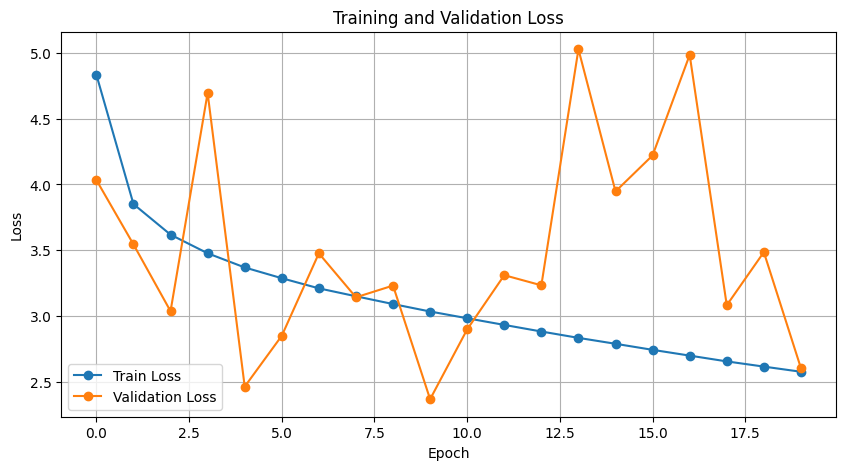

In [79]:
import matplotlib.pyplot as plt

# Read loss data from the file
with open('/content/losses/training_loss.txt', 'r') as train_file:
    train_data = train_file.readlines()

# Read validation loss data from the file
with open('/content/losses/val_loss.txt', 'r') as val_file:
    val_data = val_file.readlines()

# Split data into epochs and losses
train_epochs = [float(line.strip().split(',')[0]) for line in train_data]
train_losses = [float(line.strip().split(',')[1]) for line in train_data]
# print(train_epochs)
# print(train_losses)
val_epochs = [float(line.strip().split(',')[0]) for line in val_data]
val_losses = [float(line.strip().split(',')[1]) for line in val_data]
# print(val_epochs)
# print(val_losses)
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_losses, label='Train Loss', marker='o')
plt.plot(val_epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


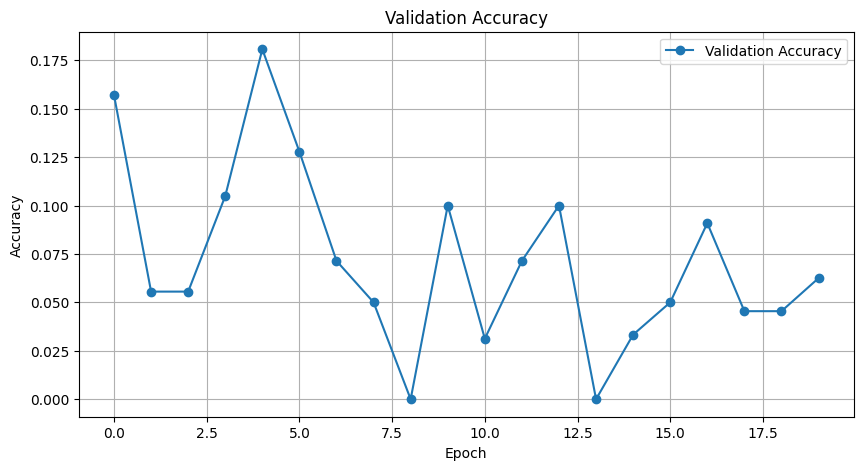

In [80]:


# Read validation accuracy data from the file
with open('/content/losses/val_accuracy.txt', 'r') as val_file:
    val_data = val_file.readlines()

val_epochs = [float(line.strip().split(',')[0]) for line in val_data]
val_accuracy = [float(line.strip().split(',')[1]) for line in val_data]
# print(val_epochs)
# print(val_accuracy)
# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(val_epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


18308 12815 5126 367 18308
Actual:একটি শিশু দাড়িয়ে আছে। দূরে একটি নৌকা আছে।
Predicted:[CLS] একজন পরষ মানষ ও একটি মরগি গোলাপ দিযের হাতে দইজন সবজ ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে দাডি । [SEP]
BLEU-1 : 0.011626811151332938


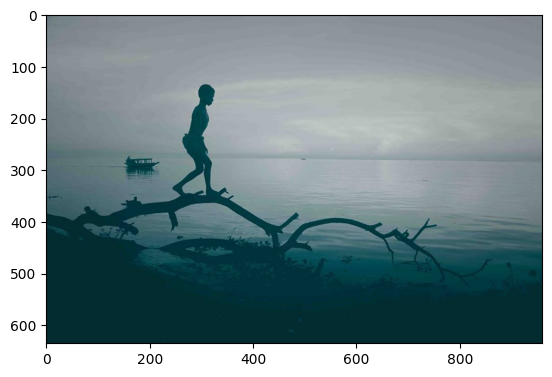

In [82]:

predicted,image_src,label=translate(200)
print(f"Actual:{label}")
print(f"Predicted:{predicted}")
print(f"BLEU-1 : {calculateSentenceBleu(predicted,label)}")
import matplotlib.pyplot as plt
image = plt.imread(image_src)
plt.imshow(image)
plt.show()


18308 12815 5126 367 18308
Actual:একজন পুরুষ দুই হাত প্রসারিত করে দাড়িয়ে আছে। কয়েকটি পাখি উড়ছে।
Predicted:[CLS] একজন পরষ মানষ ও একটি মরগি গোলাপ দিযের হাতে দইজন সবজ ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে দাডিযে দাডিযে দাডিযে দাডিযে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান গাছ । [SEP]
BLEU-1 : 0.003773646684919553


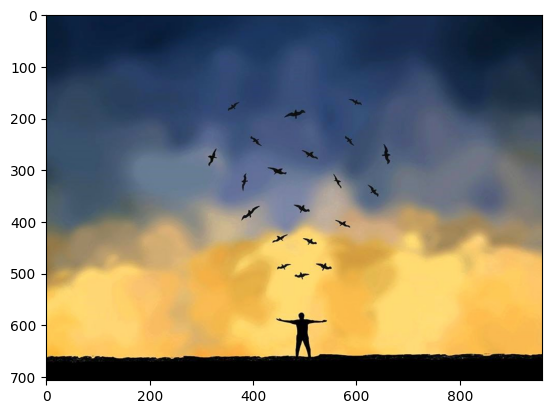

In [83]:

predicted,image_src,label=translate(300)
print(f"Actual:{label}")
print(f"Predicted:{predicted}")
print(f"BLEU-1 : {calculateSentenceBleu(predicted,label)}")
import matplotlib.pyplot as plt
image = plt.imread(image_src)
plt.imshow(image)
plt.show()


18308 12815 5126 367 18308
Actual:একজন পুরুষ দুই হাত প্রসারিত করে দাড়িয়ে আছে। কয়েকটি পাখি উড়ছে।
Predicted:[CLS] একজন পরষ মানষ ও একটি মরগি গোলাপ দিযের হাতে দইজন সবজ ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে দাডিযে দাডিযে দাডিযে দাডিযে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান গাছ । [SEP]
BLEU-1 : 0.003773646684919553


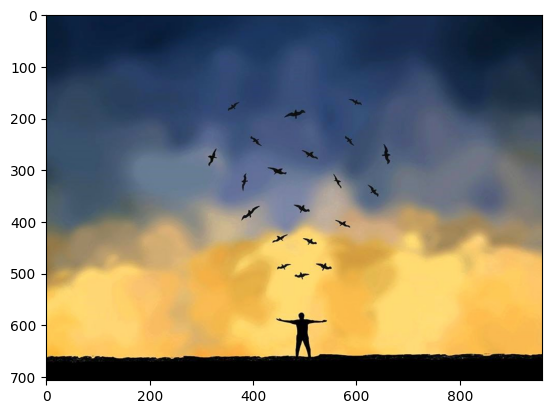

In [84]:

predicted,image_src,label=translate(300)
print(f"Actual:{label}")
print(f"Predicted:{predicted}")
print(f"BLEU-1 : {calculateSentenceBleu(predicted,label)}")
import matplotlib.pyplot as plt
image = plt.imread(image_src)
plt.imshow(image)
plt.show()

18308 12815 5126 367 18308
Actual:নৌকার উপর দুইজন মানুষ আছে।
Predicted:[CLS] একজন পরষ মানষ ও একটি মরগি গোলাপ দিযের হাতে দইজন সবজ ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে দাডিযে দাডিযে দাডিযে দাডিযে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান গাছ । [SEP]
BLEU-1 : 0


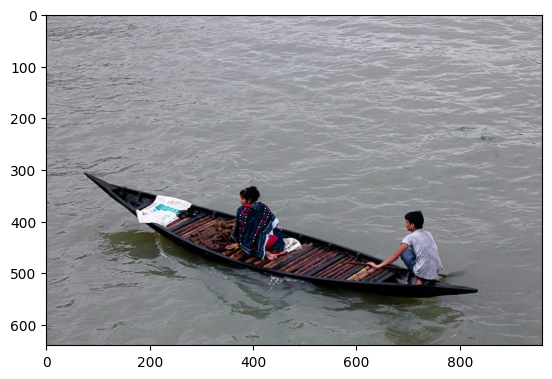

In [85]:
predicted,image_src,label=translate(6)
print(f"Actual:{label}")
print(f"Predicted:{predicted}")
print(f"BLEU-1 : {calculateSentenceBleu(predicted,label)}")
import matplotlib.pyplot as plt
image = plt.imread(image_src)
plt.imshow(image)
plt.show()

18308 12815 5126 367 18308
Actual:মাটিতে ডাল-পাতার সাথে একটা ছবি পরে আছে।
Predicted:[CLS] একজন পরষ মানষ ও একটি মরগি গোলাপ দিযের হাতে দইজন সবজ ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে দাডিযে দাডিযে দাডিযে দাডিযে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান কষেতে ধান গাছ । [SEP]
BLEU-1 : 0


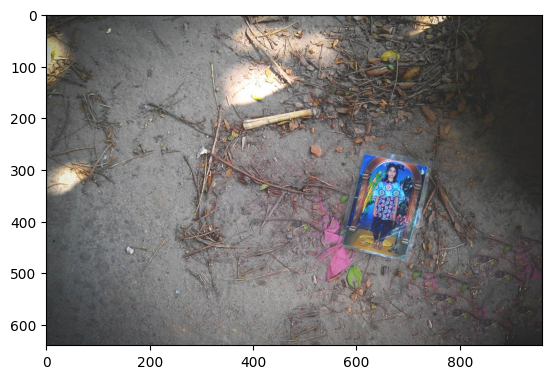

In [87]:

predicted,image_src,label=translate(55)
print(f"Actual:{label}")
print(f"Predicted:{predicted}")
print(f"BLEU-1 : {calculateSentenceBleu(predicted,label)}")
import matplotlib.pyplot as plt
image = plt.imread(image_src)
plt.imshow(image)
plt.show()
